# Kaggle simpsons data example

- simpsons 데이터를 통한 classification
- 최종 결과 시각화

&nbsp;


## Kaggle data 불러오기

In [ ]:
# Kaggle json 넣기
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
# 데이터 다운로드 kaggle api
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle/


!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
!unzip -qq "the-simpsons-characters-dataset.zip"

total 16
drwxr-xr-x 2 root root 4096 Dec 10 08:50 .
drwx------ 1 root root 4096 Dec 10 08:50 ..
-rw------- 1 root root   70 Dec 10 08:50 kaggle.json
100% 1.08G/1.08G [00:38<00:00, 30.3MB/s]
100% 1.08G/1.08G [00:38<00:00, 29.8MB/s]


## 사용할 패키지 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import shutil
import cv2
from tqdm import tqdm
import copy
from glob import glob
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

&nbsp;

## 이미지 증분 및 train : val 분할

In [ ]:
# train, val, test dataset 정의
def train_val(image_dir, ratio, transforms, batch):

  train_data = datasets.ImageFolder(image_dir, transforms)
  train_val_ratio = ratio

  # train, val 분할
  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices) # shuffle
  split = int(np.floor(train_val_ratio * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]

  # batch sampler 정의
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  # dataloader
  train_loader = DataLoader(train_data,
                            batch_size = batch,
                            sampler = train_sampler,
                            num_workers = 2)

  val_loader = DataLoader(train_data,
                            batch_size = batch,
                            sampler = train_sampler,
                            num_workers = 2)


  return train_loader, val_loader , train_data.classes

# 이미지 전처리 지정
data_transforms = transforms.Compose([
          transforms.Resize((256,256)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])


train_loader, val_loader, class_name = train_val('/content/simpsons_dataset/simpsons_dataset', 0.2, data_transforms, 32)

&nbsp;

## 데이터 시각화

In [ ]:
def show_image(image):
  image_test = image.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image_test = std * image_test + mean
  image_test = np.clip(image_test, 0, 1)

  plt.imshow(image_test)
  # plt.title(label)
  plt.show()

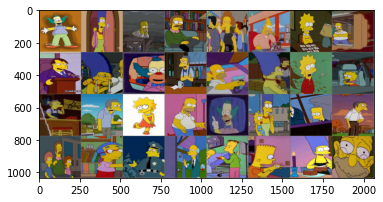

class : ['krusty_the_clown', 'marge_simpson', 'homer_simpson', 'ned_flanders', 'edna_krabappel', 'abraham_grampa_simpson', 'lisa_simpson', 'homer_simpson', 'mayor_quimby', 'marge_simpson', 'krusty_the_clown', 'moe_szyslak', 'homer_simpson', 'marge_simpson', 'lisa_simpson', 'lisa_simpson', 'moe_szyslak', 'moe_szyslak', 'lisa_simpson', 'homer_simpson', 'krusty_the_clown', 'marge_simpson', 'bart_simpson', 'moe_szyslak', 'ned_flanders', 'milhouse_van_houten', 'chief_wiggum', 'charles_montgomery_burns', 'professor_john_frink', 'bart_simpson', 'marge_simpson', 'abraham_grampa_simpson']


In [ ]:
# 배치별 데이터 가져오기
iterator = iter(train_loader)

# 배치 중에서 하나꺼내서 시각화
images, classes = next(iterator)
image = make_grid(images)

show_image(image)
print(f'class : {[class_name[i] for i in classes]}')

&nbsp;

## 모델 설계

In [ ]:
# 마지막 layer 변경
model_classification = torchvision.models.resnet50(pretrained=True)
num_fc = model_classification.fc.in_features
model_classification.fc = nn.Linear(num_fc, len(class_name))


# loss 지정
criterion = nn.CrossEntropyLoss()

# optimizer 설정
optimizer = optim.Adam(model_classification.parameters(), lr=0.001)

# gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model_classification.to(device)

# epoch
num_epochs = 100
min_loss = int(1e9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

&nbsp;

## 모델 훈련

In [ ]:
def model_train(model, data_loader, loss_fn, optimizer, device):

    model.train()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # mini-batch 학습을 시작합니다.
    for img, lbl in tqdm(data_loader):
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)

        # 누적 Gradient를 초기화
        optimizer.zero_grad()

        output = model(img)

        # 손실 계산
        loss = loss_fn(output, lbl)

        # 미분 값을 계산
        loss.backward()

        # 계산된 Gradient를 업데이트
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 계산
        _, pred = output.max(dim=1)

        # 정확히 맞춘 label의 합계를 계산
        corr += pred.eq(lbl).sum().item()

        # 평균 손실(loss) *  배치사이즈(batch size) =  배치의 전체 loss가 계산
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출
        running_loss += loss.item() * img.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도 계산
    acc = corr / len(data_loader.dataset)

    # 평균 손실(loss)과 정확도를 반환
    return running_loss / len(data_loader.dataset), acc

In [ ]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정
    model.eval()

    # Gradient 업데이트 방지
    with torch.no_grad():

        corr = 0
        running_loss = 0


        for img, lbl in tqdm(data_loader):
            img, lbl = img.to(device), lbl.to(device)
            output = model(img)
            _, pred = output.max(dim=1)
            corr += torch.sum(pred.eq(lbl)).item()
            running_loss += loss_fn(output, lbl).item() * img.size(0)

        acc = corr / len(data_loader.dataset)

        return running_loss / len(data_loader.dataset), acc

In [ ]:
# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # 훈련 손실과 정확도를 반환
    train_loss, train_acc = model_train(model, train_loader, criterion, optimizer, device)

    # 검증 손실과 검증 정확도 반환
    val_loss, val_acc = model_evaluate(model, val_loader, criterion, device)

    # val_loss 가 개선되었다면 min_loss를 갱신, model의 가중치(weights)를 저장
    if val_loss < min_loss:
        print(f'model loss 갱신 {min_loss:.5f} -> {val_loss:.5f}')
        min_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Epoch 별 결과를 출력
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 524/524 [01:05<00:00,  7.98it/s]


model loss 갱신 1000000000.00000 -> 0.45207
epoch 01, loss: 0.83220, acc: 0.59117, val_loss: 0.45207, val_accuracy: 0.67582


100%|██████████| 524/524 [01:05<00:00,  8.02it/s]


model loss 갱신 0.45207 -> 0.33608
epoch 02, loss: 0.38791, acc: 0.69388, val_loss: 0.33608, val_accuracy: 0.70711


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


model loss 갱신 0.33608 -> 0.29042
epoch 03, loss: 0.28929, acc: 0.72173, val_loss: 0.29042, val_accuracy: 0.71457


100%|██████████| 524/524 [01:06<00:00,  7.93it/s]


model loss 갱신 0.29042 -> 0.17615
epoch 04, loss: 0.22891, acc: 0.73807, val_loss: 0.17615, val_accuracy: 0.75078


100%|██████████| 524/524 [01:05<00:00,  8.04it/s]


epoch 05, loss: 0.18388, acc: 0.74977, val_loss: 0.18804, val_accuracy: 0.74963


100%|██████████| 524/524 [01:05<00:00,  8.03it/s]


epoch 06, loss: 0.16025, acc: 0.75684, val_loss: 0.17728, val_accuracy: 0.75230


100%|██████████| 524/524 [01:05<00:00,  8.03it/s]


model loss 갱신 0.17615 -> 0.09174
epoch 07, loss: 0.14753, acc: 0.75890, val_loss: 0.09174, val_accuracy: 0.77547


100%|██████████| 524/524 [01:05<00:00,  8.01it/s]


model loss 갱신 0.09174 -> 0.08109
epoch 08, loss: 0.11604, acc: 0.76840, val_loss: 0.08109, val_accuracy: 0.77648


100%|██████████| 524/524 [01:04<00:00,  8.14it/s]


epoch 09, loss: 0.12077, acc: 0.76592, val_loss: 0.10375, val_accuracy: 0.77175


100%|██████████| 524/524 [01:04<00:00,  8.13it/s]


model loss 갱신 0.08109 -> 0.05430
epoch 10, loss: 0.08886, acc: 0.77528, val_loss: 0.05430, val_accuracy: 0.78474


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


epoch 11, loss: 0.09424, acc: 0.77399, val_loss: 0.05955, val_accuracy: 0.78207


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 12, loss: 0.09216, acc: 0.77485, val_loss: 0.08764, val_accuracy: 0.77509


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 13, loss: 0.07265, acc: 0.77848, val_loss: 0.09266, val_accuracy: 0.77409


100%|██████████| 524/524 [01:04<00:00,  8.13it/s]


epoch 14, loss: 0.06309, acc: 0.78245, val_loss: 0.05938, val_accuracy: 0.78216


100%|██████████| 524/524 [01:04<00:00,  8.08it/s]


model loss 갱신 0.05430 -> 0.02945
epoch 15, loss: 0.06967, acc: 0.78016, val_loss: 0.02945, val_accuracy: 0.79248


100%|██████████| 524/524 [01:04<00:00,  8.13it/s]


epoch 16, loss: 0.06045, acc: 0.78259, val_loss: 0.09875, val_accuracy: 0.77065


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 17, loss: 0.05050, acc: 0.78522, val_loss: 0.08015, val_accuracy: 0.77805


100%|██████████| 524/524 [01:04<00:00,  8.08it/s]


epoch 18, loss: 0.04634, acc: 0.78737, val_loss: 0.05832, val_accuracy: 0.78307


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


model loss 갱신 0.02945 -> 0.02585
epoch 19, loss: 0.05687, acc: 0.78465, val_loss: 0.02585, val_accuracy: 0.79229


100%|██████████| 524/524 [01:05<00:00,  8.03it/s]


epoch 20, loss: 0.03808, acc: 0.78985, val_loss: 0.12300, val_accuracy: 0.77094


100%|██████████| 524/524 [01:04<00:00,  8.14it/s]


epoch 21, loss: 0.03824, acc: 0.78890, val_loss: 0.02652, val_accuracy: 0.79310


100%|██████████| 524/524 [01:04<00:00,  8.13it/s]


epoch 22, loss: 0.04507, acc: 0.78708, val_loss: 0.03057, val_accuracy: 0.79076


100%|██████████| 524/524 [01:05<00:00,  8.04it/s]


model loss 갱신 0.02585 -> 0.01135
epoch 23, loss: 0.04620, acc: 0.78627, val_loss: 0.01135, val_accuracy: 0.79668


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 24, loss: 0.02713, acc: 0.79215, val_loss: 0.01566, val_accuracy: 0.79602


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 25, loss: 0.03875, acc: 0.78818, val_loss: 0.02048, val_accuracy: 0.79444


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 26, loss: 0.02933, acc: 0.79186, val_loss: 0.01491, val_accuracy: 0.79592


100%|██████████| 524/524 [01:04<00:00,  8.08it/s]


epoch 27, loss: 0.03459, acc: 0.78890, val_loss: 0.07489, val_accuracy: 0.77896


100%|██████████| 524/524 [01:04<00:00,  8.12it/s]


epoch 28, loss: 0.02229, acc: 0.79387, val_loss: 0.01622, val_accuracy: 0.79568


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 29, loss: 0.03072, acc: 0.79119, val_loss: 0.01893, val_accuracy: 0.79434


100%|██████████| 524/524 [01:05<00:00,  8.04it/s]


epoch 30, loss: 0.02190, acc: 0.79453, val_loss: 0.11053, val_accuracy: 0.77027


100%|██████████| 524/524 [01:05<00:00,  8.04it/s]


model loss 갱신 0.01135 -> 0.00987
epoch 31, loss: 0.02140, acc: 0.79391, val_loss: 0.00987, val_accuracy: 0.79702


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 32, loss: 0.04289, acc: 0.78804, val_loss: 0.01001, val_accuracy: 0.79731


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 33, loss: 0.02267, acc: 0.79401, val_loss: 0.02896, val_accuracy: 0.79062


100%|██████████| 524/524 [01:04<00:00,  8.08it/s]


epoch 34, loss: 0.02932, acc: 0.79143, val_loss: 0.02463, val_accuracy: 0.79205


100%|██████████| 524/524 [01:05<00:00,  8.03it/s]


model loss 갱신 0.00987 -> 0.00424
epoch 35, loss: 0.01681, acc: 0.79539, val_loss: 0.00424, val_accuracy: 0.79907


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 36, loss: 0.02269, acc: 0.79396, val_loss: 0.00870, val_accuracy: 0.79735


100%|██████████| 524/524 [01:05<00:00,  8.03it/s]


epoch 37, loss: 0.01686, acc: 0.79520, val_loss: 0.00763, val_accuracy: 0.79750


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 38, loss: 0.01821, acc: 0.79439, val_loss: 0.01973, val_accuracy: 0.79425


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 39, loss: 0.02224, acc: 0.79368, val_loss: 0.01025, val_accuracy: 0.79764


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 40, loss: 0.01160, acc: 0.79683, val_loss: 0.00826, val_accuracy: 0.79783


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 41, loss: 0.02415, acc: 0.79224, val_loss: 0.02566, val_accuracy: 0.79310


100%|██████████| 524/524 [01:05<00:00,  8.02it/s]


epoch 42, loss: 0.03418, acc: 0.79133, val_loss: 0.01276, val_accuracy: 0.79630


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


model loss 갱신 0.00424 -> 0.00302
epoch 43, loss: 0.01072, acc: 0.79659, val_loss: 0.00302, val_accuracy: 0.79931


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


model loss 갱신 0.00302 -> 0.00221
epoch 44, loss: 0.00247, acc: 0.79950, val_loss: 0.00221, val_accuracy: 0.79965


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 45, loss: 0.02622, acc: 0.79277, val_loss: 0.01325, val_accuracy: 0.79630


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 46, loss: 0.02137, acc: 0.79368, val_loss: 0.00668, val_accuracy: 0.79840


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


epoch 47, loss: 0.01725, acc: 0.79525, val_loss: 0.01079, val_accuracy: 0.79678


100%|██████████| 524/524 [01:04<00:00,  8.08it/s]


epoch 48, loss: 0.01281, acc: 0.79645, val_loss: 0.00354, val_accuracy: 0.79912


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 49, loss: 0.01579, acc: 0.79544, val_loss: 0.05181, val_accuracy: 0.78684


100%|██████████| 524/524 [01:05<00:00,  8.02it/s]


epoch 50, loss: 0.01439, acc: 0.79654, val_loss: 0.03513, val_accuracy: 0.79043


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 51, loss: 0.01810, acc: 0.79487, val_loss: 0.02121, val_accuracy: 0.79411


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 52, loss: 0.01568, acc: 0.79549, val_loss: 0.01820, val_accuracy: 0.79473


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


epoch 53, loss: 0.02120, acc: 0.79391, val_loss: 0.00639, val_accuracy: 0.79850


100%|██████████| 524/524 [01:04<00:00,  8.12it/s]


epoch 54, loss: 0.00773, acc: 0.79778, val_loss: 0.00747, val_accuracy: 0.79735


100%|██████████| 524/524 [01:04<00:00,  8.06it/s]


epoch 55, loss: 0.01564, acc: 0.79559, val_loss: 0.00471, val_accuracy: 0.79864


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 56, loss: 0.01330, acc: 0.79654, val_loss: 0.00383, val_accuracy: 0.79912


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 57, loss: 0.01273, acc: 0.79645, val_loss: 0.03029, val_accuracy: 0.79133


100%|██████████| 524/524 [01:04<00:00,  8.06it/s]


epoch 58, loss: 0.00856, acc: 0.79769, val_loss: 0.00280, val_accuracy: 0.79898


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 59, loss: 0.00996, acc: 0.79711, val_loss: 0.00836, val_accuracy: 0.79778


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 60, loss: 0.02000, acc: 0.79449, val_loss: 0.00529, val_accuracy: 0.79812


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 61, loss: 0.01417, acc: 0.79621, val_loss: 0.00255, val_accuracy: 0.79950


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 62, loss: 0.00709, acc: 0.79774, val_loss: 0.00858, val_accuracy: 0.79817


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 63, loss: 0.01834, acc: 0.79496, val_loss: 0.00830, val_accuracy: 0.79778


100%|██████████| 524/524 [01:05<00:00,  7.98it/s]


model loss 갱신 0.00221 -> 0.00132
epoch 64, loss: 0.00510, acc: 0.79883, val_loss: 0.00132, val_accuracy: 0.79960


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 65, loss: 0.00869, acc: 0.79759, val_loss: 0.01750, val_accuracy: 0.79535


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 66, loss: 0.01234, acc: 0.79630, val_loss: 0.01360, val_accuracy: 0.79621


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 67, loss: 0.00973, acc: 0.79721, val_loss: 0.00199, val_accuracy: 0.79960


100%|██████████| 524/524 [01:04<00:00,  8.08it/s]


epoch 68, loss: 0.00533, acc: 0.79855, val_loss: 0.00154, val_accuracy: 0.79960


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 69, loss: 0.00802, acc: 0.79774, val_loss: 0.03066, val_accuracy: 0.79181


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 70, loss: 0.01594, acc: 0.79578, val_loss: 0.00988, val_accuracy: 0.79688


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 71, loss: 0.01055, acc: 0.79678, val_loss: 0.02764, val_accuracy: 0.79186


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 72, loss: 0.01186, acc: 0.79635, val_loss: 0.00247, val_accuracy: 0.79955


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 73, loss: 0.00507, acc: 0.79850, val_loss: 0.01375, val_accuracy: 0.79606


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


epoch 74, loss: 0.01289, acc: 0.79702, val_loss: 0.00602, val_accuracy: 0.79840


100%|██████████| 524/524 [01:05<00:00,  8.02it/s]


epoch 75, loss: 0.00553, acc: 0.79826, val_loss: 0.00436, val_accuracy: 0.79888


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


epoch 76, loss: 0.00894, acc: 0.79764, val_loss: 0.00573, val_accuracy: 0.79797


100%|██████████| 524/524 [01:05<00:00,  8.03it/s]


epoch 77, loss: 0.00976, acc: 0.79735, val_loss: 0.00505, val_accuracy: 0.79826


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


model loss 갱신 0.00132 -> 0.00123
epoch 78, loss: 0.00352, acc: 0.79903, val_loss: 0.00123, val_accuracy: 0.79965


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 79, loss: 0.00691, acc: 0.79788, val_loss: 0.00496, val_accuracy: 0.79879


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 80, loss: 0.01536, acc: 0.79597, val_loss: 0.00528, val_accuracy: 0.79860


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 81, loss: 0.00698, acc: 0.79802, val_loss: 0.00380, val_accuracy: 0.79912


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 82, loss: 0.01338, acc: 0.79668, val_loss: 0.00396, val_accuracy: 0.79893


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 83, loss: 0.00577, acc: 0.79855, val_loss: 0.00157, val_accuracy: 0.79960


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 84, loss: 0.00416, acc: 0.79879, val_loss: 0.00463, val_accuracy: 0.79874


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 85, loss: 0.00423, acc: 0.79869, val_loss: 0.00478, val_accuracy: 0.79879


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 86, loss: 0.00847, acc: 0.79793, val_loss: 0.02340, val_accuracy: 0.79415


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 87, loss: 0.01600, acc: 0.79544, val_loss: 0.01716, val_accuracy: 0.79511


100%|██████████| 524/524 [01:05<00:00,  8.06it/s]


model loss 갱신 0.00123 -> 0.00058
epoch 88, loss: 0.00338, acc: 0.79888, val_loss: 0.00058, val_accuracy: 0.79993


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 89, loss: 0.00410, acc: 0.79879, val_loss: 0.00552, val_accuracy: 0.79850


100%|██████████| 524/524 [01:04<00:00,  8.10it/s]


epoch 90, loss: 0.01437, acc: 0.79611, val_loss: 0.00107, val_accuracy: 0.79974


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


epoch 91, loss: 0.00695, acc: 0.79778, val_loss: 0.00209, val_accuracy: 0.79960


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 92, loss: 0.00807, acc: 0.79774, val_loss: 0.00073, val_accuracy: 0.79979


100%|██████████| 524/524 [01:04<00:00,  8.11it/s]


epoch 93, loss: 0.00874, acc: 0.79735, val_loss: 0.00315, val_accuracy: 0.79941


100%|██████████| 524/524 [01:05<00:00,  8.03it/s]


epoch 94, loss: 0.00344, acc: 0.79922, val_loss: 0.00201, val_accuracy: 0.79960


100%|██████████| 524/524 [01:05<00:00,  8.04it/s]


epoch 95, loss: 0.00169, acc: 0.79960, val_loss: 0.00195, val_accuracy: 0.79946


100%|██████████| 524/524 [01:05<00:00,  8.05it/s]


epoch 96, loss: 0.01608, acc: 0.79602, val_loss: 0.01405, val_accuracy: 0.79544


100%|██████████| 524/524 [01:04<00:00,  8.07it/s]


epoch 97, loss: 0.00503, acc: 0.79879, val_loss: 0.00360, val_accuracy: 0.79912


100%|██████████| 524/524 [01:05<00:00,  8.02it/s]


epoch 98, loss: 0.00418, acc: 0.79907, val_loss: 0.00076, val_accuracy: 0.79984


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]


epoch 99, loss: 0.01127, acc: 0.79735, val_loss: 0.00690, val_accuracy: 0.79812


100%|██████████| 524/524 [01:04<00:00,  8.09it/s]

epoch 100, loss: 0.00929, acc: 0.79735, val_loss: 0.00161, val_accuracy: 0.79955


- 최고 score의 model 다운

In [ ]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

&nbsp;

## 테스트 데이터로 검증

- 최고의 스코어 모델 load

In [ ]:
checkpoint =  torch.load('best_model.pth')

model_classification = torchvision.models.resnet50(pretrained=True)
num_fc = model_classification.fc.in_features
model_classification.fc = nn.Linear(num_fc, len(class_name))
model = model_classification.to(device)

model.load_state_dict(checkpoint)

<All keys matched successfully>

- test 데이터 label, data 분리

In [ ]:
test_data = glob('./kaggle_simpson_testset/kaggle_simpson_testset/*.jpg')

os.mkdir('test_data')

for file_name in test_data:
  sep = file_name.split('kaggle_simpson_testset/')[-1].split('_')

  name = '_'.join(sep[:-1])
  number = sep[-1]

  if os.path.exists(f'./test_data/{name}') == False:
    os.mkdir(f'./test_data/{name}')


  shutil.move(file_name, f'./test_data/{name}/{number}')

- test_loader 설정

In [ ]:
test = datasets.ImageFolder('./test_data', data_transforms)
ans_class = test.classes
test_loader = DataLoader(test,
                         shuffle=True,
                          batch_size = 1,
                          num_workers = 2)

- 결과 확인

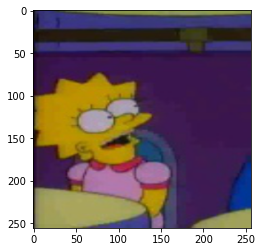


pred_class : lisa_simpson
answer : lisa_simpson


In [ ]:
# 배치별 데이터 가져오기
iterator = iter(test_loader)
images, classes = next(iterator)


with torch.no_grad():
  model.eval()
  outputs = model(images.to(device))
  _, preds  = torch.max(outputs, dim=1)


  image = make_grid(images)
  show_image(image)
  print()
  print(f'pred_class : {class_name[preds[0].item()]}')
  print(f'answer : {ans_class[classes.item()]}')